In [6]:
# Module Import
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from datetime import timedelta
import json
from IPython.display import display
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    GRU, LSTM, Bidirectional,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    LayerNormalization, MultiHeadAttention, Add
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tcn import TCN

In [7]:
# 데이터 전처리
data = pd.read_csv("../frontend/public/sensor.csv")

all_zero_cols = data.columns[(data == 0).all()].tolist()
all_nan_cols = data.columns[data.isna().all()].tolist()
threshold = 1.2
low_std_cols = data.std(numeric_only=True).loc[lambda x: x < threshold].index.tolist()
useless_columns = list(set(all_zero_cols + all_nan_cols + low_std_cols))
data = data.drop(columns=useless_columns)

status_map = {'NORMAL': 0, 'RECOVERING': 1, 'BROKEN': 2}
data['machine_status_encoded'] = data['machine_status'].map(status_map)

data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data = data.interpolate(method='time')

sensor_cols = [col for col in data.columns if col.startswith('sensor')]
scaler = StandardScaler()
data[sensor_cols] = scaler.fit_transform(data[sensor_cols])

data = data.drop(columns=['machine_status'])
data = data.sort_index()
data.columns

C:\Users\LEETJ\AppData\Local\Temp\ipykernel_6700\1390813879.py:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='time')


Index(['Unnamed: 0', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_19', 'sensor_20', 'sensor_21',
       'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26',
       'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31',
       'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36',
       'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41',
       'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46',
       'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51',
       'machine_status_encoded'],
      dtype='object')

In [8]:
# 데이터 분할 학습(60%), 테스트(40%)
total_rows = len(data)
split_idx = int(total_rows * 0.6)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

print(total_rows)
print(len(train_data))
print(len(test_data))

220320
132192
88128


In [9]:
# 상태 예측 window 생성
def create_windows_fast(data, window_size=60, step=1, label_col='machine_status_encoded'):
    sensor_cols = [col for col in data.columns if col.startswith('sensor')]
    sensor_data = data[sensor_cols].to_numpy(dtype=np.float32)
    label_data = data[label_col].to_numpy(dtype=np.int8)

    num_windows = (len(sensor_data) - window_size) // step
    X = np.empty((num_windows, window_size, len(sensor_cols)), dtype=np.float32)
    y = np.empty(num_windows, dtype=np.int8)

    for i in range(num_windows):
        idx = i * step
        X[i] = sensor_data[idx:idx + window_size]
        y[i] = label_data[idx + window_size]

    return X, y

X_train, y_train = create_windows_fast(train_data)
X_test, y_test = create_windows_fast(test_data)

In [10]:
# 모델 학습
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0
)

xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))
y_pred_xgb=y_pred

report_xgb = classification_report(
    y_test, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN'], output_dict=True
)

# LightGBM
lgbm_model = lgb.LGBMClassifier(
    n_estimators      = 200,
    max_depth        = -1,
    learning_rate    = 0.05,
    num_leaves       = 64,
    objective        = 'multiclass',
    class_weight     = None,
    subsample        = 0.8,
    colsample_bytree = 0.8,
    n_jobs           = -1,
    random_state     = 42
)

lgbm_model.fit(
    X_train.reshape(X_train.shape[0], -1),
    y_train
)

y_pred = lgbm_model.predict(
    X_test.reshape(X_test.shape[0], -1)
)
y_pred_lgbm=y_pred

report_lgbm = classification_report(
    y_test, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN'], output_dict=True
)

# 1D-CNN
y_train_cnn = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_cnn = tf.keras.utils.to_categorical(y_test, num_classes=3)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_model.fit(
    X_train, y_train_cnn,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=0
)

y_pred_proba = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cnn, axis=1)
y_pred_cnn=y_pred

report_cnn = classification_report(
    y_true, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN'], output_dict=True
)

# LSTM
y_train_lstm = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_lstm = tf.keras.utils.to_categorical(y_test, num_classes=3)

lstm_model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train_lstm,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=0
)

y_pred_proba = lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)
y_pred_lstm=y_pred

report_lstm = classification_report(
    y_true, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN'], output_dict=True
)

c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.024545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733380
[LightGBM] [Info] Number of data points in the train set: 132132, number of used features: 2940
[LightGBM] [Info] Start training from score -0.079739
[LightGBM] [Info] Start training from score -2.569090
[LightGBM] [Info] Start training from score -10.182119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packa

2753/2753 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

2753/2753 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step


c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [11]:
# 전체 예측 F1-score 비교
df_xgb = pd.DataFrame(report_xgb).T
print("\n[XGBoost Classification Report]")
display(df_xgb)

df_lgbm = pd.DataFrame(report_lgbm).T
print("\n[LightGBM Classification Report]")
display(df_lgbm)

df_cnn = pd.DataFrame(report_cnn).T
print("\n[1D-CNN Classification Report]")
display(df_cnn)

df_lstm = pd.DataFrame(report_lstm).T
print("\n[LSTM Classification Report]")
display(df_lstm)


[XGBoost Classification Report]


,precision,recall,f1-score,support
NORMAL,0.999916,0.995953,0.997931,83771.00000
RECOVERING,0.926550,0.998603,0.961228,4295.00000
BROKEN,0.000000,0.000000,0.000000,2.00000
accuracy,0.996060,0.996060,0.996060,0.99606
macro avg,0.642155,0.664852,0.653053,88068.00000
weighted avg,0.996315,0.996060,0.996118,88068.00000



[LightGBM Classification Report]


,precision,recall,f1-score,support
NORMAL,0.998979,0.981533,0.990179,83771.00000
RECOVERING,0.731424,0.980908,0.837991,4295.00000
BROKEN,0.000000,0.000000,0.000000,2.00000
accuracy,0.981480,0.981480,0.981480,0.98148
macro avg,0.576801,0.654147,0.609390,88068.00000
weighted avg,0.985908,0.981480,0.982735,88068.00000



[1D-CNN Classification Report]


,precision,recall,f1-score,support
NORMAL,0.999893,0.894820,0.944443,83771.00000
RECOVERING,0.327328,0.998370,0.493015,4295.00000
BROKEN,0.000000,0.000000,0.000000,2.00000
accuracy,0.899850,0.899850,0.899850,0.89985
macro avg,0.442407,0.631064,0.479153,88068.00000
weighted avg,0.967070,0.899850,0.922406,88068.00000



[LSTM Classification Report]


,precision,recall,f1-score,support
NORMAL,0.999823,0.675353,0.806164,83771.000000
RECOVERING,0.136105,0.997672,0.239533,4295.000000
BROKEN,0.000000,0.000000,0.000000,2.000000
accuracy,0.691057,0.691057,0.691057,0.691057
macro avg,0.378643,0.557675,0.348566,88068.000000
weighted avg,0.957678,0.691057,0.778512,88068.000000


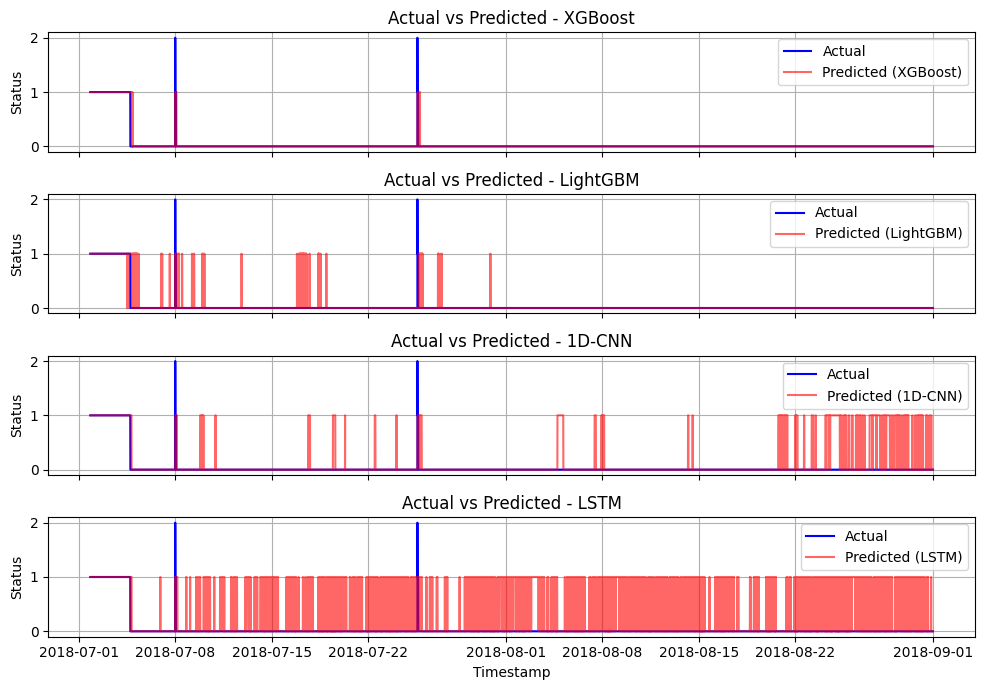

In [12]:
# 전체 예측 결과 차트로 비교
window_size = 60
timestamps = test_data.index[window_size:]

df_plot = pd.DataFrame({
    "timestamp": timestamps,
    "actual": y_test.flatten(),
    "XGBoost": y_pred_xgb,
    "LightGBM": y_pred_lgbm,
    "1D-CNN": y_pred_cnn,
    "LSTM": y_pred_lstm
})

model_names = ['XGBoost', 'LightGBM', '1D-CNN', 'LSTM']
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True)

for i, model in enumerate(model_names):
    axes[i].plot(df_plot["timestamp"], df_plot["actual"], color="blue", label="Actual")
    axes[i].plot(df_plot["timestamp"], df_plot[model], color="red", alpha=0.6, label=f"Predicted ({model})")
    axes[i].set_ylabel("Status")
    axes[i].set_title(f"Actual vs Predicted - {model}")
    axes[i].grid(True)
    axes[i].legend(loc="upper right")

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()

In [15]:
# RECOVERING 시점 데이터
# 3시간 이내인 경우 동일 집단으로 가정
test_timestamps = test_data.index[window_size:]
test_rec_times = test_timestamps[y_pred_xgb == 1].tolist()

test_rec_times = sorted(test_rec_times)

distinct_rec_times = []
prev_time = None
max_gap = timedelta(hours=3)

for current_time in test_rec_times:
    if prev_time is None or (current_time - prev_time) > max_gap:
        distinct_rec_times.append(current_time)
    prev_time = current_time

for t in distinct_rec_times:
    print(t.strftime('%Y-%m-%d %H:%M:%S'))


2018-07-01 20:12:00
2018-07-08 00:14:00
2018-07-25 14:00:00
